# COMP9033 - Data Analytics Lab 04: Outlier detection and cleaning
## Introduction

This week's lab is focused on outlier detection and data cleaning. At the end of the lab, you should be able to use pandas to:

- Create histograms and boxplots to help find outliers visually.
- Remove data from a data frame.
- Replace data in a data frame.

### Getting started

Let's start by making sure that plots are displayed inline by issuing the *magic command* `%matplotlib inline` and importing pandas in the usual way.

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

Next, let's load the data. Write the path to your iris.csv file (i.e. the one from Lab 03) in the cell below:

In [3]:
path_to_csv = "data/iris.csv"

Execute the cell below to load the data into a pandas data frame and index that data frame by the `species` and `sample_number` columns:

In [4]:
df = pd.read_csv(path_to_csv, index_col=['species', 'sample_number'])
df.head()

sepal_length  sepal_width  petal_length  petal_width
species sample_number                                                      
setosa  1                       5.1          3.5           1.4          0.2
        2                       4.9          3.0           1.4          0.2
        3                       4.7          3.2           1.3          0.2
        4                       4.6          3.1           1.5          0.2
        5                       5.0          3.6           1.4          0.2

## Finding outliers
### Histograms

Last week, we looked at how pandas can be used to plot histograms for columns in our data frame. For instance, to create a histogram for each column, we can write:

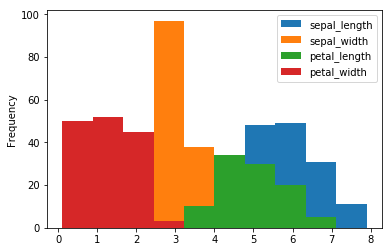

In [5]:
df.plot(kind='hist')

We also saw how data frame indexing can be used to limit our view of the data to just one species of Iris. For instance, to plot a histogram for each column in our data frame, but only for the rows corresponding to *Iris versicolor*, we can write:

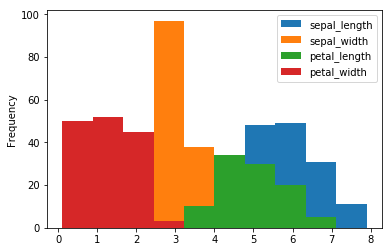

In [7]:
versicolor = df.ix['versicolor']
versicolor.plot(kind='hist')

Plotting multiple histograms on one chart can be a little cluttered though. We also saw how we could create individual charts for each column by passing `subplots=True` when we call the `plot` method, like this:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58f2efc890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f58f2b6f310>]], dtype=object)

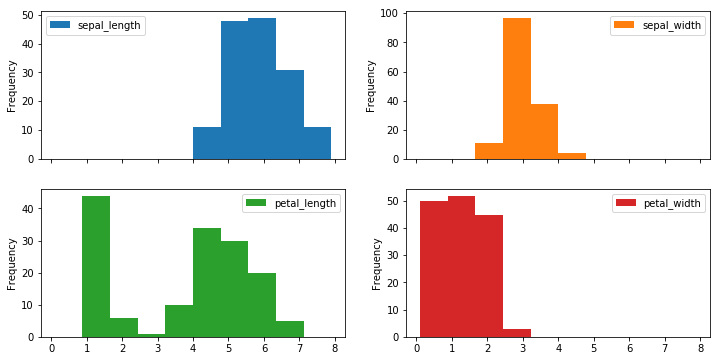

In [8]:
versicolor.plot(kind='hist', subplots=True, layout=(2,2), figsize=(12,6))

This is much more useful, but the histograms look a bit chunky because the default number of bins is set to ten. We can change this easily though, by passing the optional `bins` argument to the `plot` method, like in the cell below.

> **Note:** By default, `bins=10` unless other specified. Increasing the number of bins results in a "higher resolution" histogram, but comes at the cost of additional visual complexity. The trade off here is important. If we set the number of bins to be a very large number, the histogram will become much more detailed, but also more difficult to understand and interpret. On the other hand, if the number of bins is too small, then the bin widths will be very wide (i.e. the histogram will look "chunky") and important details may be hidden.

> Choosing the right number of bins depends on your data and how much detail you're looking for, so it can change from situation to situation. As a general rule, you should stick with the default setting initially, and only increase or decrease this if you feel that it is necessary.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84a19905d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f84a17e9450>]], dtype=object)

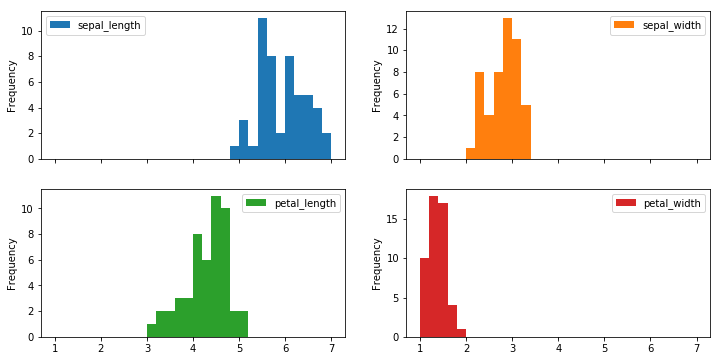

In [10]:
versicolor.plot(kind='hist', subplots=True, layout=(2,2), figsize=(12,6), bins=30)

Increasing the number of bins gives us a more detailed view of how the data is behaving, which can often make it easier to detect outliers visually. In this instance, however, it seems that all of the data is reasonably well behaved - there are no obvious extreme values.

### Boxplots

Boxplots offer an alternative method for visually detecting outliers. In pandas, boxplots aren't supported through the standard `plot` method, but instead through a separate [`boxplot`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.boxplot.html) method. However, apart from this, they operate in more or less the same way, like in the cell below.

> **Note:** Depending on the version of pandas you are running, calling the `boxplot` method may generate a warning about the `return_type` argument not being set. This is just a warning to users that this functionality may change in a future release, and can safely be ignored as the behaviour in either case will not affect the result of the plotting call for our purposes.

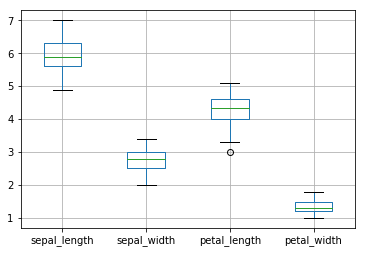

In [11]:
versicolor.boxplot()

As you can see, pandas creates a boxplot for each column in our data frame and places all four boxplots in the same chart, so that we can compare the distributions of the data in the columns side by side.

Inspecting the boxplots, it becomes clear that (at least according to the logic of the boxplot test) there are some outlying observations in our petal length data. In this instance, the outlier is not far from the lower whisker of the box plot (i.e. it's not a *very* extreme value), and so we may not want to go to the effort of dealing with it because it may not affect the outcome of any further analysis very severly. However, let's consider that it is an undesirable observation and we want to deal with it in some fashion.


## Removing and replacing data

As we discussed in this week's lecture, we have three options for dealing with outliers:

1. Remove them.
2. Replace them with a "reasonable" value.
3. Adjust how we model the data.

In this instance, we don't have a particular modelling technique in mind, so adjusting how we model the data isn't really an option. However, we can choose to either remove the data or replace it with some value that would be considered reasonable.

### Removing data

In order to remove an observation, we must first identify its indices in the data frame. We can do this by manually computing the whisker values and using them to identify the locations of the outliers:

> **Note:** Typically, the lower whisker in a boxplot is set to be $1.5 \times \text{IQR}$ *below the bottom edge* of the box, while the upper whisker is set to be $1.5 \times \text{IQR}$ *above the top edge* of the box, where $\text{IQR}$ is the interquartile range, i.e. the distance betwen the top and bottom edges of the box.

In [12]:
# Here, be = bottom edge, te = top edge, iqr = interquartile range, lw = lower whisker, uw = upper whisker
be = versicolor.quantile(0.25)
te = versicolor.quantile(0.75)
iqr = te - be
lw = be - 1.5 * iqr
uw = te + 1.5 * iqr

# Outliers are below the lower whisker OR above the upper whisker
outliers = (versicolor < lw) | (versicolor > uw)

# Print the last few rows of "outliers"
outliers.tail()

,sepal_length,sepal_width,petal_length,petal_width
sample_number,,,,
46,False,False,False,False
47,False,False,False,False
48,False,False,False,False
49,False,False,True,False
50,False,False,False,False


As you can see, the outlier occurs in the 49th row of the data frame.

To remove the row containing the outlying value, we first compute a copy of the data frame *without* the outlying value. To do this, we can just select all the entries *not contained* (`~`) in the `outliers` variable we computed earlier, like this:

In [15]:
versicolor[~outliers].tail()

,sepal_length,sepal_width,petal_length,petal_width
sample_number,,,,
46,5.7,3.0,4.2,1.2
47,5.7,2.9,4.2,1.3
48,6.2,2.9,4.3,1.3
49,5.1,2.5,NaN,1.1
50,5.7,2.8,4.1,1.3


Next, we call the [`dropna`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) method on the dataframe to remove all the rows containing outlying values:

In [14]:
removed = versicolor[~outliers].dropna()
removed.tail() # Just show the last five rows

,sepal_length,sepal_width,petal_length,petal_width
sample_number,,,,
45,5.6,2.7,4.2,1.3
46,5.7,3.0,4.2,1.2
47,5.7,2.9,4.2,1.3
48,6.2,2.9,4.3,1.3
50,5.7,2.8,4.1,1.3


As you can see, the 49th row (where the outlier was) has now been removed.

### Replacing data

If we have multiple rows and columns of data, then removing one point means we must remove the entire row or the entire column it belongs to. This is often inconvenient because we end up removing several more data points than just the one we intended to, and so our sample becomes smaller.

One alternative to removing a data point is to replace it with a suitable substitute value. Determining an appropriate substitution can be subjective, but two commonly used choices are the mean and the median. Let's replace the outlying point in our original data frame (i.e. `df`) with the median value of the sample it belongs to. To do this, we must first compute the median value of the sample, which we can do using the [`median`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.median.html#pandas.DataFrame.median) method of the data frame, just like in Lab 02:

In [16]:
versicolor.median()

sepal_length    5.90
sepal_width     2.80
petal_length    4.35
petal_width     1.30
dtype: float64

To set the new value, we first compute a copy of the data frame *without* the outlying value, just like earlier. Then, we can call the [`fillna`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna) method to fill any missing column values with the median values of those columns, like this:

In [17]:
replaced = versicolor[~outliers].fillna(versicolor.median())
replaced.tail() # Just show the last five rows

,sepal_length,sepal_width,petal_length,petal_width
sample_number,,,,
46,5.7,3.0,4.20,1.2
47,5.7,2.9,4.20,1.3
48,6.2,2.9,4.30,1.3
49,5.1,2.5,4.35,1.1
50,5.7,2.8,4.10,1.3
